In [1]:
#Add the folder to the path:
import sys
sys.path.append('../')
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from qutip.expect import expect
import numpy as np
from util.samplers_util import thermal_rejection
import matplotlib.pyplot as plt
from util.basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
print(os.getcwd())
from util.functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py
from util.fitting_functions_ZNE import linear_ZNE, third_no_first_ZNE, quadratic_only_ZNE, exp_ZNE, log_fit_exp_ZNE, gaussian_ZNE


/Users/thomassteckmann/Duke_Analog_ZNE_data


In [3]:
# import all the useful lib in python
from matplotlib import artist as art
%matplotlib inline
import scipy as sp
# import pandas as pd
import pathlib
import os
import datetime as dt
import glob
from IPython.display import clear_output
from numpy.fft import fft, ifft

from util.h5analysis import *
from util.qsim_functions import*


In [4]:
#Pairs:
# wait_times = [0.000000, 0.119841, 0.359523, 0.719045, 0.958727, 1.198409, 1.797613, 2.396818, 3.595226]
# data_names = ['000558346','000558347','000558348','000558349','000558350','000558352']
# data_folder = 'Jij_Extrapolation'
data_names = ['217', '218', '219', '220', '221', '222', '223', '224', '225']
wait_times = [0.000000, 0.096831, 0.290494, 0.580987, 0.774650, 0.968312, 1.452468, 1.936624, 2.904936]
rescale_factors = np.array([1.0043137885234383,1.0076825611745364,1.0144201064767326 ,1.024526424430027,1.031263969732223,1.0380015150344193,1.0548453782899099,1.0716892415454002, 1.1053769680563812])

data_names = ['162']#, '165', '166']#, '220', '221', '222', '223', '224', '225']
wait_times = [0.000000]#, 0.096831, 0.290494, 0.580987, 0.774650, 0.968312, 1.452468, 1.936624, 2.904936]
rescale_factors = np.array([1.0043137885234383])#,1.0076825611745364,1.0144201064767326 ,1.024526424430027,1.031263969732223,1.0380015150344193,1.0548453782899099,1.0716892415454002, 1.1053769680563812])

data_names = ['361', '376', '459', '467', '513', '525', '575']
wait_times = np.array([0.00, 0.122, 0.367, 0.734, 0.979, 1.22, 1.84])
rescale_factors = np.array([0.05829266, 0.06488966, 0.07813772, 0.09798277, 0.11123083, 0.12426259,0.1577883 ])/0.0583

data_names = ['361', '376', '451', '467', '513', '525', '575']
wait_times = np.array([0.00, 0.122, 0.367, 0.734, 0.979, 1.22, 1.84])
rescale_factors = np.array([0.05434279, 0.06122253, 0.07503841, 0.09573403, 0.10954991, 0.12314022,0.15810285 ])/0.0543

data_names = ['253', '269', '314', '344', '362', '375', '392']
wait_times = np.array([0.00, 0.122, 0.367, 0.734, 0.979, 1.22, 1.84])
rescale_factors = np.array([0.05283631, 0.06002285, 0.07445482, 0.09607334, 0.11050532, 0.12470167 ,0.16122342])/0.0528

data_folder = 'ROUND_2_JIJ_MITIGATION'
data_folder = '12-13-Jij_check'
data_folder = '12_13_good_Jij'
data_folder = '12_13_good_Jij_v2'
data_folder = '2_qubit_12_20_r1'


pair = (15,16)
theta_0 = 0.0583
theta_dot = .0211
shots = 600
converter = 1/409.6
theta_list = theta_0+ theta_dot*np.array(wait_times)*converter*1e3
full_data_folder_path = './data/' + data_folder + '/'
for name_index in range(len(data_names)):
    name = data_names[name_index]
    if '000610' in name: #000563
        pass
    else:
        name = '000610' + name
        data_names[name_index] = name
        

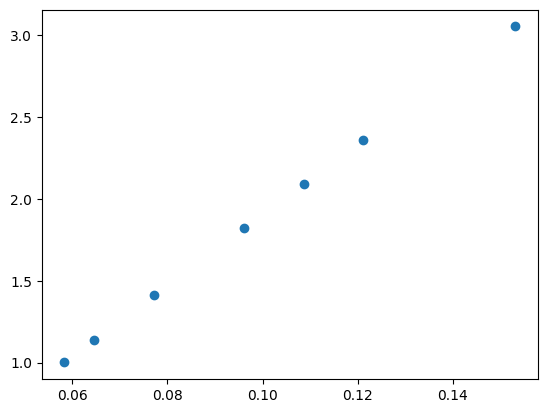

In [5]:
plt.plot(theta_list, rescale_factors, 'o')
#fit to a line:
def linear(x, a, b):
    return a*x + b

#popt, pcov = curve_fit(linear, theta_list, rescale_factors)
#plt.plot(theta_list, linear(theta_list, *popt))
#print(popt)
dense_theta = np.linspace(0, 0.15, 100)
#dense_rescale = linear(dense_theta, *popt)
#dense_rescale correction:
#correction = (1+theta_0*popt[0])**2
#print(correction)
#for i in range(len(dense_rescale)):
#    dense_rescale[i] = max(1, dense_rescale[i])


In [6]:
print()
COUNTS_THRESHOLD = 1

print(os.getcwd())



/Users/thomassteckmann/Duke_Analog_ZNE_data


In [7]:
#time steps:
time_points = 31


results = np.zeros((len(data_names), time_points))
leakage_matrix = np.zeros((time_points, len(data_names)))
flopping_matrix = np.zeros((time_points, len(data_names)))
flopping_std_matrix = np.zeros((time_points, len(data_names)))
flopping_matrix_ps = np.zeros((time_points, len(data_names)))
times = None

for file_id_index in range(len(data_names)):
    file_id = data_names[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts.shape)
    measurements = np.zeros((2, shots, time_points))
    for pair_index in range(len(pair)):
        qubit = pair[pair_index]
        measurements[pair_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots, time_points), dtype='<U5')
    expectations = np.zeros((shots, time_points))
    ps_expectations = np.zeros((time_points,),dtype=list)
    #Set each element in ps_expectations to []
    for i in range(time_points):
        ps_expectations[i] = []
        
    for j in range(time_points):
        for i in range(shots):
            expectation = ((measurements[0,i,j]*2-1) - (measurements[1,i,j]*2-1))/2
            bitstring = str(int(measurements[0,i,j])) + str(int(measurements[1,i,j]))
            #print(bitstring)
            counts_bitstrings[i,j] = bitstring
            expectations[i,j] = expectation
            if bitstring == '00' or bitstring == '11':
                pass
            else:
                ps_expectations[j].append(expectation)
    ps_expecations_avg = np.array([np.mean(ps_expectations[i]) for i in range(time_points)])
    flopping_matrix_ps[:,file_id_index] = ps_expecations_avg
    #Post select and split bitsrings back into single qubits:
    #average expectations across the 150 axis:
    expectations_avg = np.mean(expectations, axis=0)
    #Convert counts_bitstrings to a dictionary of counts
    print(counts_bitstrings)
    counts_array  = np.zeros((time_points,), dtype=dict)
    for i in range(time_points):
        counts_array[i] = {}
        for j in range(shots):
            if counts_bitstrings[j,i] in counts_array[i]:
                counts_array[i][counts_bitstrings[j,i]] += 1
            else:
                counts_array[i][counts_bitstrings[j,i]] = 1
    
        

    

    leakage = np.zeros((time_points,))
    for i in range(time_points):
        if '00' in counts_array[i]:
            leakage[i] += counts_array[i]['00']/shots
        if '11' in counts_array[i]:
            leakage[i] += counts_array[i]['11']/shots
            
        
            
    leakage_conv = np.zeros((time_points,))
    for i in range(time_points):
        leakage_conv[i] = np.mean(leakage[i:i+3])
    leakage_matrix[:,file_id_index] = leakage#leakage_conv
    flopping_matrix[:,file_id_index] = expectations_avg
    flopping_std = np.std(expectations, axis=0)
    flopping_std_matrix[:,file_id_index] = flopping_std

#Dived each elemnt of expecation by the associated element 1-leakage:
rescale_expectations = np.zeros((time_points, len(data_names)))
for i in range(time_points):
    rescale_expectations[i,:] = flopping_matrix[i,:]/(1-leakage_matrix[i,:])

[0.        0.1346125 0.269225  0.4038375 0.53845   0.6730625 0.807675
 0.9422875 1.0769    1.2115125 1.346125  1.4807375 1.61535   1.7499625
 1.884575  2.0191875 2.1538    2.2884125 2.423025  2.5576375 2.69225
 2.8268625 2.961475  3.0960875 3.2307    3.3653125 3.499925  3.6345375
 3.76915   3.9037625 4.038375 ]
(23, 600, 31)
[['10' '10' '10' ... '10' '10' '10']
 ['10' '10' '10' ... '10' '00' '11']
 ['10' '10' '10' ... '01' '10' '01']
 ...
 ['10' '01' '10' ... '11' '10' '11']
 ['10' '10' '10' ... '01' '01' '10']
 ['10' '01' '10' ... '01' '01' '11']]
[0.        0.1346125 0.269225  0.4038375 0.53845   0.6730625 0.807675
 0.9422875 1.0769    1.2115125 1.346125  1.4807375 1.61535   1.7499625
 1.884575  2.0191875 2.1538    2.2884125 2.423025  2.5576375 2.69225
 2.8268625 2.961475  3.0960875 3.2307    3.3653125 3.499925  3.6345375
 3.76915   3.9037625 4.038375 ]
(23, 600, 31)
[['10' '10' '10' ... '00' '00' '10']
 ['10' '10' '10' ... '01' '01' '01']
 ['10' '10' '10' ... '01' '10' '01']
 ...
 [

In [8]:
#Fit each data set to exp(-gamma*t)*cos(omega*t)
#Create a new data set flopping_matrix_fit
flopping_matrix_fit = np.zeros(flopping_matrix.shape)
flopping_std_matrix_fit = np.zeros(flopping_matrix.shape)
def exp_func (t, gamma, omega, A):
    return A*np.exp(-gamma*t)*np.cos(omega*t)

print(flopping_matrix.shape)
Omega = np.zeros((len(data_names),))
for i in range(len(data_names)):
    popt, pcov = curve_fit(exp_func, times, flopping_matrix[:,i], p0=[0.04, 1, 1])
    print(exp_func(times, *popt))
    Omega[i] = popt[1]
    flopping_matrix_fit[:,i] = exp_func(times, *popt)
    #flopping_std_matrix_fit[:,i] = np.sqrt(np.diag(pcov))

(31, 7)
[ 1.02751925  0.78508635  0.27391013 -0.28879616 -0.68810852 -0.79130671
 -0.58922504 -0.18743831  0.2444642   0.54245277  0.60867039  0.44137083
  0.12605487 -0.20504866 -0.42691454 -0.46762756 -0.32994053 -0.08285576
  0.17066325  0.33544706  0.35883558  0.24610563  0.05276767 -0.14110613
 -0.26317082 -0.27501981 -0.18314606 -0.03207599  0.11599885  0.20616066
  0.21052313]
[ 1.02571127  0.78537501  0.28021583 -0.27722297 -0.67654905 -0.78672659
 -0.59630991 -0.20562049  0.22141797  0.52400214  0.60330892  0.45262379
  0.1505424  -0.17653696 -0.40573712 -0.46256507 -0.34345542 -0.10994464
  0.14052519  0.31407734  0.35458716  0.26053621  0.08007569 -0.11169116
 -0.24305849 -0.2717629  -0.19757296 -0.05814451  0.0886491   0.18804829
  0.2082448 ]
[ 1.00551495  0.73666114  0.19354392 -0.36539809 -0.70590557 -0.7124123
 -0.42196458  0.00934381  0.38543499  0.55652361  0.47587946  0.20698995
 -0.11595192 -0.35225241 -0.41398308 -0.29625647 -0.06937482  0.15934635
  0.294599    0.

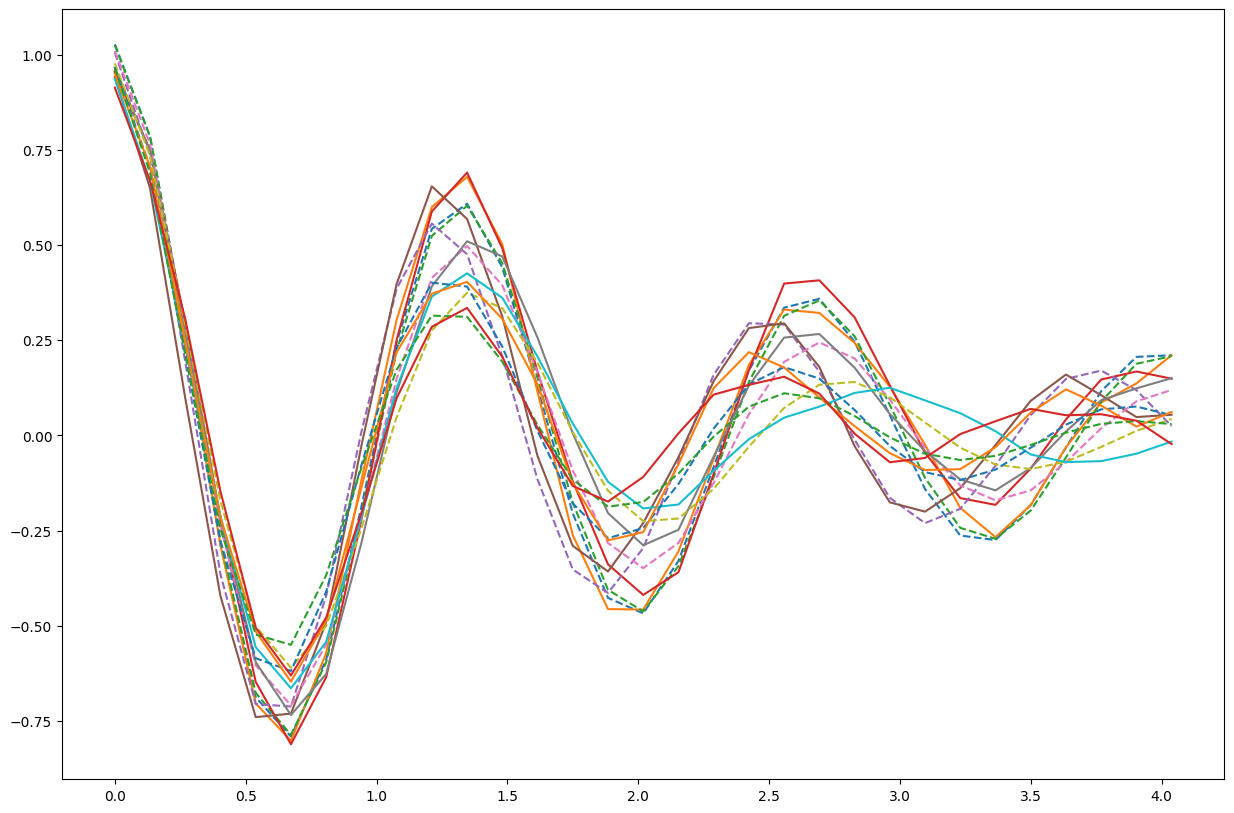

In [9]:
#Smooth out the data, not by taking an average over points but using fancier python methods
flopping_matrix_smooth = np.zeros(flopping_matrix.shape)
flopping_std_matrix_smooth = np.zeros(flopping_matrix.shape)
flopping_ps_smoothed = np.zeros(flopping_matrix_ps.shape)

#Use teh Savitzky-Golay filter
from scipy.signal import savgol_filter
for i in range(len(data_names)):
    flopping_matrix_smooth[:,i] = savgol_filter(flopping_matrix[:,i], 5, 3)
    flopping_ps_smoothed[:,i] = savgol_filter(flopping_matrix_ps[:,i], 5, 3)
    #flopping_std_matrix_smooth[i,:] = savgol_filter(flopping_std_matrix[i,:], 7, 2)

#Plot the data
fig, ax = plt.subplots(1,1, figsize=(15,10))
for i in range(len(data_names)):
    #ax.errorbar(times, flopping_matrix[i,:], yerr=flopping_std_matrix[i,:], fmt='o', label='Data ' + str(i))
    ax.plot(times, flopping_matrix_fit[:,i], label='Fit ' + str(i), linestyle='--')
    ax.plot(times, flopping_matrix_smooth[:,i], label='Smooth ' + str(i))




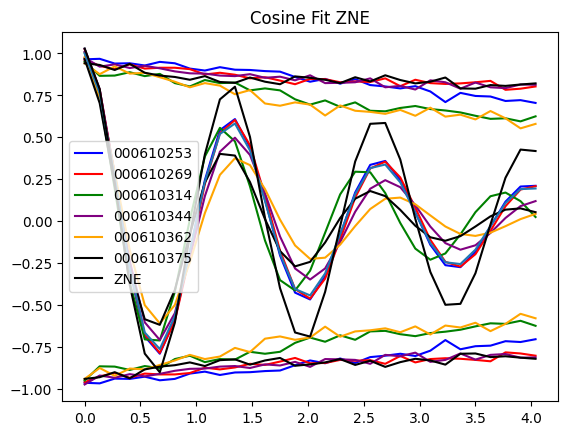

In [10]:
theta_sub_index = [0, 1, 2, 3, 4,5]#, 5,6,]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))

#flopping_fit_rescaled = 
ZNE_function = third_no_first_ZNE
color_list = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'yellow']

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = color_list[index]#cmap(name_index/len(data_names))
    #if data_names[name_index] == '000609376':
    #    color = 'black'
    plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
    plt.plot(times, flopping_matrix_fit[:,name_index], color = color)
    #plt.errorbar(times, flopping_matrix[:,name_index], label = data_names[name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    plt.plot(times, -1+leakage_matrix[:,name_index], color = color)

plt.plot(times, np.exp(-0.4*times)*np.cos(Omega[0]*times))
decoherence_limit = np.exp(-0.4*times)*np.cos(Omega[0]*times)
#Get ZNed Data:
ZNE_data = np.zeros(time_points)
for i in range(time_points):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix_fit[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_data[i] = fit_func(0)
plt.title('Cosine Fit ZNE')
plt.plot(times, ZNE_data, label = 'ZNE', color = 'black')
plt.legend()

Text(0, 0.5, 'Expectation Value <Z_0> - <Z_1>')

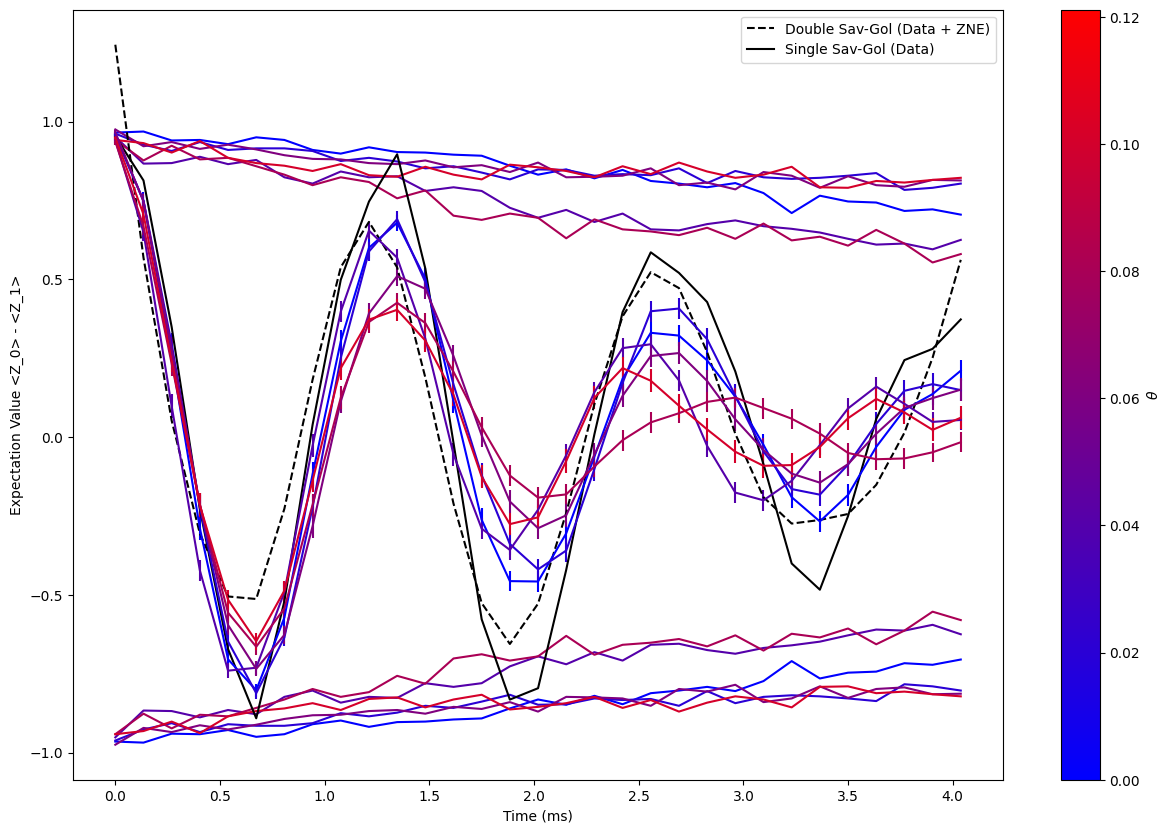

In [11]:
#theta_sub_index = [0]#, 1, 2, 3, 4]#, 5,6,]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))

fig, ax = plt.subplots(1,1, figsize=(15,10))

ZNE_function = third_no_first_ZNE

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = cmap(name_index/len(theta_sub_index))
    ax.plot(times, 1-leakage_matrix[:,name_index],  color = color)
    #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
    ax.errorbar(times, flopping_matrix_smooth[:,name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    ax.plot(times, -1+leakage_matrix[:,name_index],  color = color)


#Get ZNed Data:
ZNE_data = np.zeros(time_points)
for i in range(time_points):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix_smooth[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_data[i] = fit_func(0)
    
#Apply the Sav-Gol filter to the ZNE data
ZNE_data_smooth = savgol_filter(ZNE_data, 10, 2)
ax.plot(times, ZNE_data_smooth, label = 'Double Sav-Gol (Data + ZNE)', color = 'black', linestyle = '--')

ax.plot(times, ZNE_data, label = 'Single Sav-Gol (Data)', color = 'black')

ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(theta_list[theta_sub_index_mask])))
#sm.set_label('Temperature (Theta)')
#Add the color bar to the plot:

cbar = fig.colorbar(sm, ax=ax)

cbar.set_label(r'$\theta$')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Expectation Value <Z_0> - <Z_1>')

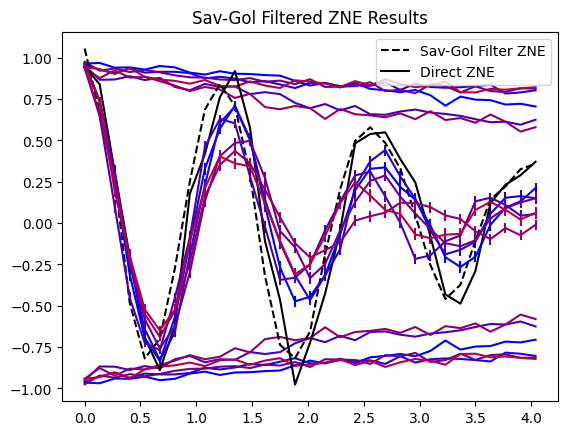

In [12]:
#theta_sub_index = [0]#, 1, 2, 3, 4]#, 5,6,]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))

ZNE_function = third_no_first_ZNE

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = cmap(name_index/len(data_names))
    plt.plot(times, 1-leakage_matrix[:,name_index], color = color)
    #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
    plt.errorbar(times, flopping_matrix[:,name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    plt.plot(times, -1+leakage_matrix[:,name_index], color = color)


#Get ZNed Data:
ZNE_data = np.zeros(time_points)
for i in range(time_points):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_data[i] = fit_func(0)
    
ZNE_data_smooth = savgol_filter(ZNE_data, 6, 2)
plt.plot(times, ZNE_data_smooth, label = 'Sav-Gol Filter ZNE', color = 'black', linestyle = '--')
plt.title('Sav-Gol Filtered ZNE Results')
plt.plot(times, ZNE_data, label = 'Direct ZNE', color = 'black')
plt.legend()


In [13]:
# #theta_sub_index = [0, 1, 2, 3, 4]#, 5,6,]
# theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
# weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
# weights_comp = np.ones(len(theta_sub_index))

# ZNE_function = third_no_first_ZNE

# cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
# for index in range(len(theta_sub_index)):
#     name_index = theta_sub_index[index]
#     color = cmap(name_index/len(data_names))
#     #plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
#     #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
#     plt.errorbar(times, rescale_expectations[:,name_index], label = data_names[name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
#     #plt.plot(times, -1+leakage_matrix[:,name_index], label = data_names[name_index], color = color)


# #Get ZNed Data:
# ZNE_data = np.zeros(time_points)
# for i in range(time_points):
#     #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
#     fit_func = ZNE_function(theta_list[theta_sub_index_mask], rescale_expectations[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
#     ZNE_data[i] = fit_func(0)

# plt.plot(times, np.cos(Omega[0]*times), label = 'Ideal', color = 'g')
# ZNE_data_smooth = savgol_filter(ZNE_data, 6, 2)
# plt.plot(times, ZNE_data_smooth, label = 'Sav-Gol ZNE', color = 'r')
# plt.title('Post Selected + Filtered (synthetic, rescaling from leakage)')

# plt.plot(times, ZNE_data, label = 'Raw ZNE', color = 'k', linestyle='--')

In [14]:
#flopping_ps_smoothed = 

In [15]:
# #theta_sub_index = [0, 1, 2, 3, 4]#, 5,6,]
# theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
# weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
# weights_comp = np.ones(len(theta_sub_index))

# ZNE_function = third_no_first_ZNE

# cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
# for index in range(len(theta_sub_index)):
#     name_index = theta_sub_index[index]
#     color = cmap(index/len(theta_sub_index))
#     #plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
#     #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
#     plt.errorbar(times, flopping_matrix_ps[:,name_index], label = data_names[name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
#     #plt.plot(times, -1+leakage_matrix[:,name_index], label = data_names[name_index], color = color)


# #Get ZNed Data:
# ZNE_data = np.zeros(time_points)
# for i in range(time_points):
#     #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
#     fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix_ps[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
#     ZNE_data[i] = fit_func(0)

# plt.plot(times, np.cos(Omega[0]*times), label = 'Ideal', color = 'g')
# ZNE_data_smooth = savgol_filter(ZNE_data, 6, 2)
# plt.plot(times, ZNE_data_smooth, label = 'Sav-Gol ZNE', color = 'r')
# plt.title('Post Selected + Filtered')
# plt.ylim(-1,1)
# plt.plot(times, ZNE_data, label = 'Raw ZNE', color = 'k', linestyle='--')

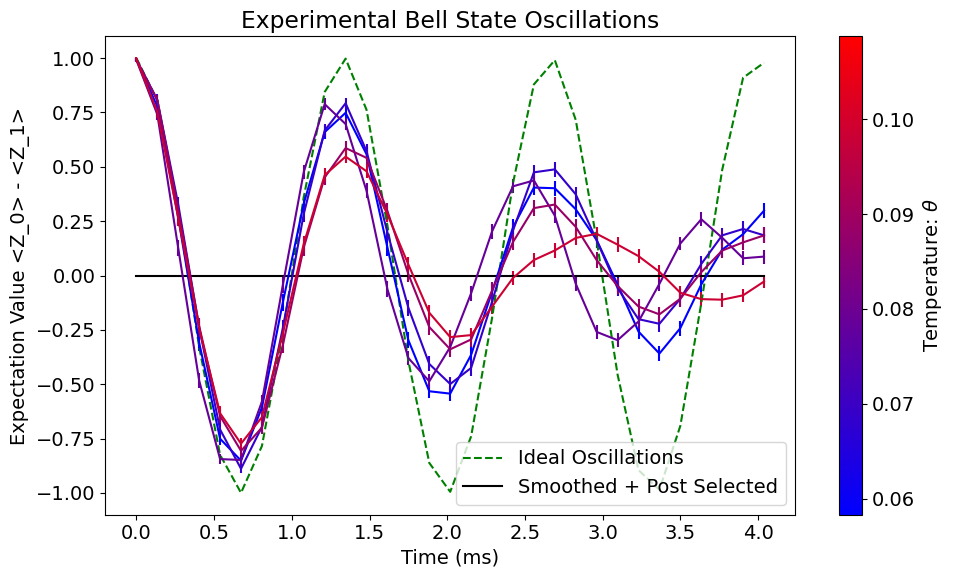

In [22]:
#theta_sub_index = [0, 1, 2, 3, 4]#, 5,6,]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))
#Make font size 16
plt.rcParams.update({'font.size': 14})

ZNE_function = third_no_first_ZNE
fig, ax = plt.subplots(1,1, figsize=(10,6))

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = cmap(index/len(theta_sub_index))
    #plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
    #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
    ax.errorbar(times, flopping_ps_smoothed[:,name_index],  yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    #plt.plot(times, -1+leakage_matrix[:,name_index], label = data_names[name_index], color = color)

#Get ZNed Data:
ZNE_data = np.zeros(time_points)
#for i in range(time_points):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    #fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_ps_smoothed[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    #ZNE_data[i] = fit_func(0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(theta_list), vmax=max(theta_list[theta_sub_index_mask])))
#sm.set_label(r'Temperature ($\lambda$)')
#Add the color bar to the plot:
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'Temperature: $\theta$')

ax.plot(times, np.cos(Omega[0]*times), label = 'Ideal Oscillations', color = 'g', linestyle='--')
ZNE_data_smooth = savgol_filter(ZNE_data, 6, 2)
ax.plot(times, ZNE_data_smooth, label = 'Smoothed + Post Selected', color = 'k')
ax.set_title('Experimental Bell State Oscillations')
ax.set_ylabel('Expectation Value <Z_0> - <Z_1>')
ax.set_xlabel('Time (ms)')
ax.set_ylim(-1.1,1.1)
#ax.plot(times, ZNE_data, label = 'ZNE', color = 'k', linestyle='--')
ax.legend()
fig.tight_layout()
plt.savefig('ZNE_Bell_State_Oscillations.png', dpi=600)

#save_all_data
#save times, tehta_list, flopping_ps_smoothed, flopping_std_matrix, shots, Omega
np.savez('plotting_data_fig_4_12-20_v1', times=times, theta_list=theta_list, flopping_ps_smoothed=flopping_ps_smoothed, flopping_std_matrix=flopping_std_matrix, shots=shots, Omega=Omega, leakage_matrix=leakage_matrix, flopping_matrix=flopping_matrix, flopping_matrix_fit=flopping_matrix_fit, flopping_matrix_smooth=flopping_matrix_smooth)
 

In [17]:
#np.savez('plotting_data_fig_4_12-13_good', times=times, theta_list=theta_list, flopping_ps_smoothed=flopping_ps_smoothed, flopping_std_matrix=flopping_std_matrix, shots=shots, Omega=Omega, leakage_matrix=leakage_matrix, flopping_matrix=flopping_matrix, flopping_matrix_fit=flopping_matrix_fit, flopping_matrix_smooth=flopping_matrix_smooth)


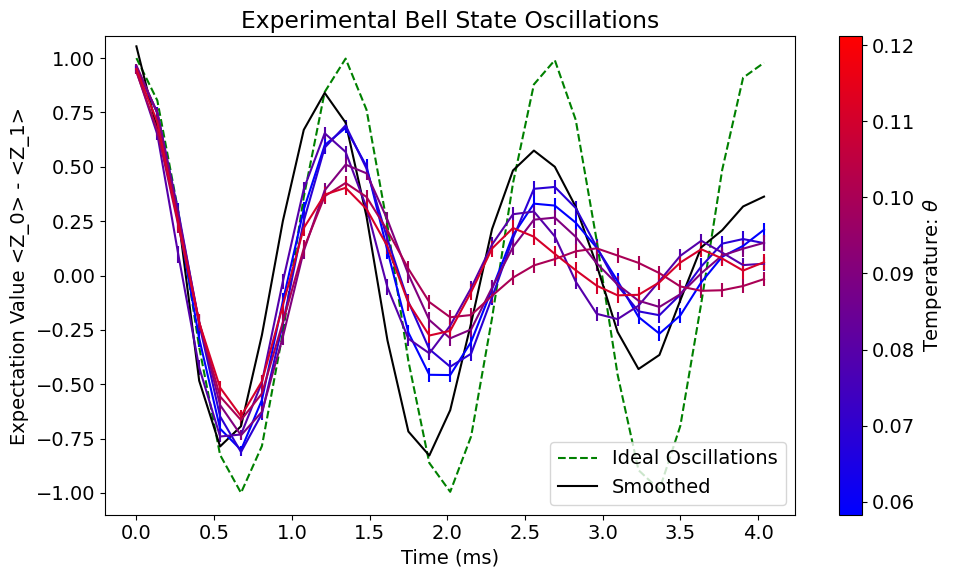

In [18]:
#theta_sub_index = [0, 1, 2, 3, 4]#, 5,6,]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))
#Make font size 16
plt.rcParams.update({'font.size': 14})

ZNE_function = third_no_first_ZNE
fig, ax = plt.subplots(1,1, figsize=(10,6))

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = cmap(index/len(theta_sub_index))
    #plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
    #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
    ax.errorbar(times, flopping_matrix_smooth[:,name_index],  yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    #plt.plot(times, -1+leakage_matrix[:,name_index], label = data_names[name_index], color = color)

#Get ZNed Data:
ZNE_data = np.zeros(time_points)
for i in range(time_points):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix_smooth[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_data[i] = fit_func(0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(theta_list), vmax=max(theta_list[theta_sub_index_mask])))
#sm.set_label(r'Temperature ($\lambda$)')
#Add the color bar to the plot:
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'Temperature: $\theta$')

ax.plot(times, np.cos(Omega[0]*times), label = 'Ideal Oscillations', color = 'g', linestyle='--')
ZNE_data_smooth = savgol_filter(ZNE_data, 6, 2)
ax.plot(times, ZNE_data_smooth, label = 'Smoothed', color = 'k')
ax.set_title('Experimental Bell State Oscillations')
ax.set_ylabel('Expectation Value <Z_0> - <Z_1>')
ax.set_xlabel('Time (ms)')
ax.set_ylim(-1.1,1.1)
#ax.plot(times, ZNE_data, label = 'ZNE', color = 'k', linestyle='--')
ax.legend()
fig.tight_layout()
plt.savefig('ZNE_Bell_State_Oscillations_no_PS.png', dpi=600)

In [19]:
print(np.max(flopping_ps_smoothed[5:,:]))
#0.64 = max contrast first peak
print(np.max(flopping_ps_smoothed[22:,:]))
#0.30 = max contrast second peak
print(np.max(ZNE_data_smooth[5:]))
#0.94 = ZNE first peak
print(np.max(ZNE_data_smooth[22:]))
#0.66 = ZNE second peak

print(np.max(flopping_matrix_smooth[5:,:]))
#0.64 = max contrast first peak
print(np.max(flopping_matrix_smooth[22:,:]))
#0.30 = max contrast second peak
print(np.max(ZNE_data_smooth[5:]))
#0.94 = ZNE first peak
print(np.max(ZNE_data_smooth[22:]))
#0.66 = ZNE second peak







0.7922833612010796
0.298331694644072
0.8399031341830409
0.36297642215942305
0.6904761904761905
0.21049999999999994
0.8399031341830409
0.36297642215942305


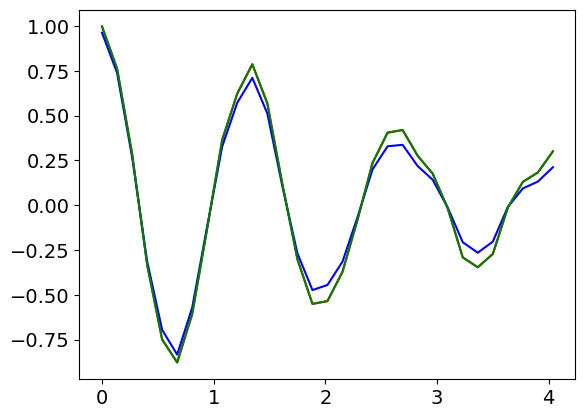

In [20]:
#plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
plt.plot(times, flopping_matrix_ps[:,0], label = data_names[name_index], color = 'r')
plt.plot(times, flopping_matrix[:,0], label = data_names[name_index], color = 'b')
plt.plot(times, rescale_expectations[:,0], label = data_names[name_index], color = 'g')


In [21]:
theta_sub_index = [0, 1, 2, 3, 4]#, 5,6,]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))

smooth_rescale = np.zeros((30, len(data_names)))
for i in range(len(data_names)):
    smooth_rescale[:,i] = savgol_filter(rescale_expectations[:,i], 5, 3)

ZNE_function = third_no_first_ZNE

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = cmap(name_index/len(data_names))
    #plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
    #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
    plt.errorbar(times, smooth_rescale[:,name_index], label = data_names[name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    #plt.plot(times, -1+leakage_matrix[:,name_index], label = data_names[name_index], color = color)


#Get ZNed Data:
ZNE_data = np.zeros(time_points)
for i in range(time_points):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], smooth_rescale[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_data[i] = fit_func(0)
exact = np.cos(Omega[0]*times)
plt.plot(times, np.cos(Omega[0]*times), label = 'Ideal', color = 'g')
ZNE_data_smooth = savgol_filter(ZNE_data, 6, 2)
plt.plot(times, ZNE_data_smooth, label = 'Double Sav-Gol', color = 'r')
plt.title('Post Selected + Filtered (synthetic, rescaling from leakage)')

plt.plot(times, ZNE_data, label = 'Single Sav-Gold (data)', color = 'k', linestyle='--')

ValueError: could not broadcast input array from shape (31,) into shape (30,)

[1.         1.10210802 1.30632513 1.6126492  1.8168663  2.02108235
 2.53162353 3.04216471 4.06324706]


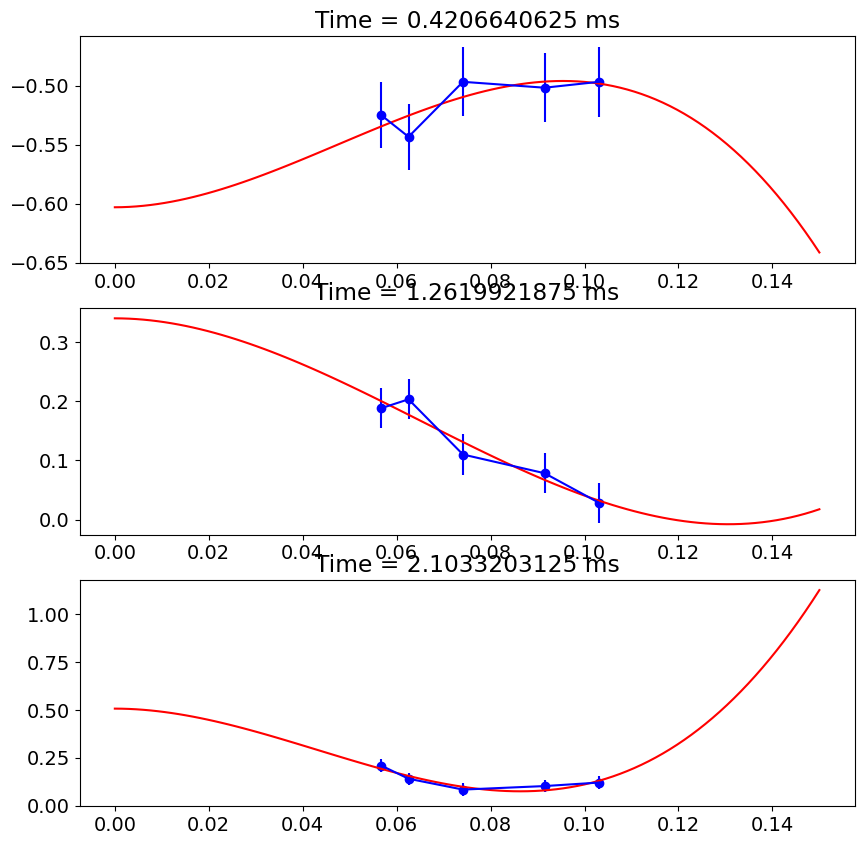

In [ ]:
peak_indices = [5,15,25]
#create 3 subplots. at the peak index, plot vs. theta, fit to cubic_no_first, and plot the fit
#thetas_sub_index = 
print(theta_list/theta_list[0])

fig, axes = plt.subplots(3)

for i in range(3):
    axis = axes[i]
    axis.scatter(theta_list[theta_sub_index_mask], flopping_matrix[peak_indices[i],theta_sub_index_mask], label = 'Data', color = 'blue')
    axis.errorbar(theta_list[theta_sub_index_mask], flopping_matrix[peak_indices[i],theta_sub_index_mask], yerr = flopping_std_matrix[peak_indices[i],theta_sub_index_mask]/np.sqrt(shots)*weights_comp, label = 'Data', color = 'blue')
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix[peak_indices[i],theta_sub_index_mask], weights=flopping_std_matrix[peak_indices[i],theta_sub_index_mask]/np.sqrt(shots)*weights_comp)#, flopping_matrix[peak_indices[i],1], flopping_matrix[peak_indices[i],2], flopping_matrix[peak_indices[i],3])
    axis.plot(dense_theta, fit_func(dense_theta), label = 'Fit', color = 'red')
    axis.set_title('Time = ' + str(times[peak_indices[i]]) + ' ms')
    #axis.scatter(dense_theta, dense_sim_flopping_decay[i,:])
    #Make the plots bigger:
    
fig.set_size_inches(10, 10)
    
    
    

In [ ]:
#Dense fake_data
#Simulating the Jij XX oscillations with active heating + maybe dephasing noise
"""How to deal with active heating of the chain?
Option 1: increase the random theta linearly in time. Probably the best bet. 
Option 2: rescample ever few time steps with a higher temperature.

I think option 1 is the best for now
"""
sx, sy, sz = get_s_lists(2)

omega_sim = Omega[0]
rabi_freq = np.sqrt(omega_sim)

decay_envelope = lambda t: np.exp(-t*0.4)
time_decay_factors = decay_envelope(times)
#dephasing:
#rate = 0
#rate = 0
noisy_ops = [sx[0], sx[1]]
obs = [0.5*(sz[0] - sz[1])]

HXX = sx[0] * sx[1]
#HXX = HXX* Omega**2

def genH(theta_0, theta_dot, Omega):
    HXX = sx[0] * sx[1]

    HXX = HXX * Omega/2
    delta = thermal_rejection(theta_0,1)[0]
    #delta=0
    return HXX*((1-2*delta))


psi0 = tensor(basis(2,0), basis(2,1))

#import Options from qutip:
from qutip.solver import Options
#increase nsteps
options = Options(nsteps=1e3)

def run(theta_0, theta_dot,Omega):
    #print('running')
    H = genH(theta_0,theta_dot,Omega)
    results = mesolve(H, psi0,times, [], obs, options=options).expect[0]#, ntraj=1)
    #print(results)
    #print(results)
    return np.array(results)
shots = 1000


#full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, theta_dot,Omega) for i in range(shots))
    

def gen_full_results(theta_0, theta_dot,Omega, return_std=False):
    #H = genH(theta_0, theta_dot)
    full_results = np.array(Parallel(n_jobs=6)(delayed(run)(theta_0, theta_dot,Omega) for _ in range(shots)))
    #print(full_results.shape)
    averaged = np.zeros(len(times))
    #print(averaged.shape)
    #Compute the standard deviation of the simulated data:
    
    for item in full_results:
        #print(item.expect[0])
        averaged += item
    averaged = averaged/shots
    std_sum = 0
    for item in full_results:
        std_sum += (item - averaged)**2
    std_sum = std_sum/shots
    if return_std:
        return averaged, std_sum
    else:
        return averaged
    #return averaged, std_sum#[indices]


In [ ]:
print(rescale_factors)
print(dense_rescale)

[1.00431379 1.00768256 1.01442011 1.02452642 1.03126397 1.03800152
 1.05484538 1.07168924 1.10537697]
[0.97132161 0.97220266 0.97308371 0.97396475 0.9748458  0.97572685
 0.97660789 0.97748894 0.97836999 0.97925103 0.98013208 0.98101313
 0.98189417 0.98277522 0.98365627 0.98453731 0.98541836 0.98629941
 0.98718046 0.9880615  0.98894255 0.9898236  0.99070464 0.99158569
 0.99246674 0.99334778 0.99422883 0.99510988 0.99599092 0.99687197
 0.99775302 0.99863406 0.99951511 1.00039616 1.0012772  1.00215825
 1.0030393  1.00392035 1.00480139 1.00568244 1.00656349 1.00744453
 1.00832558 1.00920663 1.01008767 1.01096872 1.01184977 1.01273081
 1.01361186 1.01449291 1.01537395 1.016255   1.01713605 1.01801709
 1.01889814 1.01977919 1.02066024 1.02154128 1.02242233 1.02330338
 1.02418442 1.02506547 1.02594652 1.02682756 1.02770861 1.02858966
 1.0294707  1.03035175 1.0312328  1.03211384 1.03299489 1.03387594
 1.03475698 1.03563803 1.03651908 1.03740013 1.03828117 1.03916222
 1.04004327 1.04092431 1.04

In [ ]:
print((dense_rescale**2*dense_rescale/dense_rescale))
print((1+dense_theta/2)**2)

[0.94346567 0.94517801 0.9468919  0.94860734 0.95032433 0.95204288
 0.95376298 0.95548463 0.95720783 0.95893259 0.9606589  0.96238676
 0.96411617 0.96584714 0.96757965 0.96931372 0.97104935 0.97278652
 0.97452525 0.97626553 0.97800737 0.97975075 0.98149569 0.98324218
 0.98499022 0.98673982 0.98849097 0.99024367 0.99199792 0.99375373
 0.99551108 0.99726999 0.99903046 1.00079247 1.00255604 1.00432116
 1.00608783 1.00785606 1.00962584 1.01139717 1.01317005 1.01494449
 1.01672047 1.01849801 1.02027711 1.02205775 1.02383995 1.0256237
 1.027409   1.02919586 1.03098427 1.03277423 1.03456574 1.03635881
 1.03815342 1.03994959 1.04174732 1.04354659 1.04534742 1.0471498
 1.04895373 1.05075922 1.05256625 1.05437484 1.05618499 1.05799668
 1.05980993 1.06162473 1.06344108 1.06525899 1.06707845 1.06889946
 1.07072202 1.07254613 1.0743718  1.07619902 1.07802779 1.07985812
 1.08169    1.08352343 1.08535841 1.08719494 1.08903303 1.09087267
 1.09271386 1.09455661 1.0964009  1.09824675 1.10009416 1.101943

In [ ]:
#For each theta in dense_theta, pair it with dense_rescale, and generate the output from gen_ful_results. Combine into a matrix called dense_sim_flopping. 
#dense_theta = np.linspace(0, 0.5, 10)
dense_sim_flopping = np.zeros((len(times), len(dense_theta)))
dense_sim_flopping_std = np.zeros((len(times), len(dense_theta)))
print(dense_sim_flopping[:,0].shape)
for i in range(len(dense_theta)):
    result, std = gen_full_results(dense_theta[i], theta_dot, Omega[0]*correction*(dense_rescale[i]**2*dense_rescale[i]/dense_rescale[i]), return_std=True)
    #print(result.shape)
    dense_sim_flopping[:,i] = result
    dense_sim_flopping_std[:,i] = std
#multiply the time axis by the time_decay_factors
print(dense_theta.shape)


(30,)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


KeyboardInterrupt: 

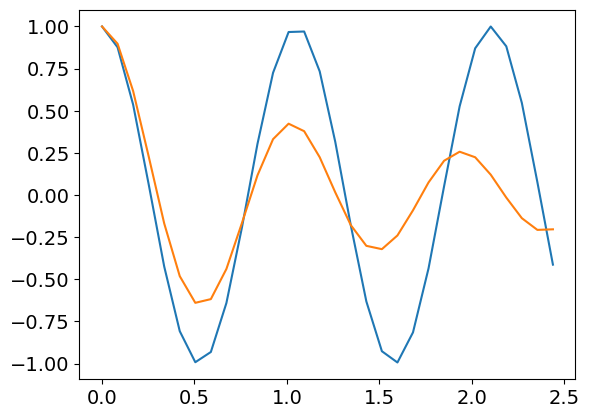

In [ ]:
plt.plot(times, dense_sim_flopping[:,0])
plt.plot(times, dense_sim_flopping[:,-1])

In [ ]:
print(dense_sim_flopping[:,0]*time_decay_factors)
print(dense_sim_flopping[:,0])

[ 1.          0.84753497  0.50172225  0.05808654 -0.37060371 -0.68250499
 -0.81041317 -0.73562718 -0.48927717 -0.14161474  0.21738252  0.50087553
  0.64578636  0.62638022  0.45800696  0.19074548 -0.1048677  -0.35608774
 -0.50555202 -0.52403655 -0.41563358 -0.21460162  0.02481465  0.2426955
  0.38818651  0.43110519  0.3678345   0.22046116  0.02980543 -0.15558874]
[ 1.          0.87654253  0.53665365  0.06425717 -0.42400524 -0.80757462
 -0.99174196 -0.93103355 -0.64043916 -0.19171088  0.30435349  0.72526855
  0.96710419  0.97014757  0.73364711  0.3159983  -0.17967499 -0.63098387
 -0.92649366 -0.99323848 -0.81473797 -0.43506654  0.0520291   0.52627792
  0.87058109  0.99992498  0.88237255  0.54694918  0.07647609 -0.41287996]


In [ ]:
print(dense_sim_flopping.shape)
print(time_decay_factors.shape)
dense_sim_flopping_decay = np.zeros(dense_sim_flopping.shape)
for i in range(len(dense_theta)):
    dense_sim_flopping_decay[:,i] = dense_sim_flopping[:,i]*time_decay_factors


#dense_sim_flopping_decay = np.dot(dense_sim_flopping, time_decay_factors, axis=0)


(30, 100)
(30,)


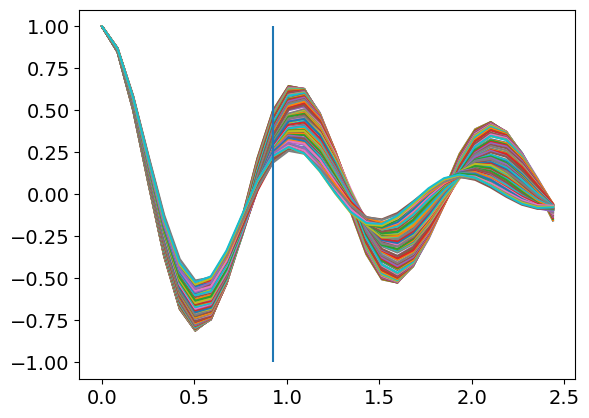

In [ ]:
for i in range(len(dense_theta)):
    plt.plot(times, dense_sim_flopping_decay[:,i])
plt.vlines(times[11], -1, 1)


<ErrorbarContainer object of 3 artists>

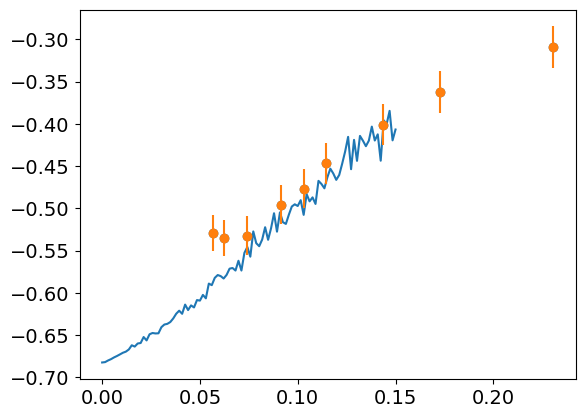

In [ ]:
time_index = 5
plt.plot(dense_theta, dense_sim_flopping_decay[time_index,:])
plt.scatter(theta_list, flopping_matrix_smooth[time_index,:])
plt.errorbar(theta_list, flopping_matrix_smooth[time_index,:], yerr = flopping_std_matrix[time_index,:]/np.sqrt(shots), fmt='o')


0.05303030303030303


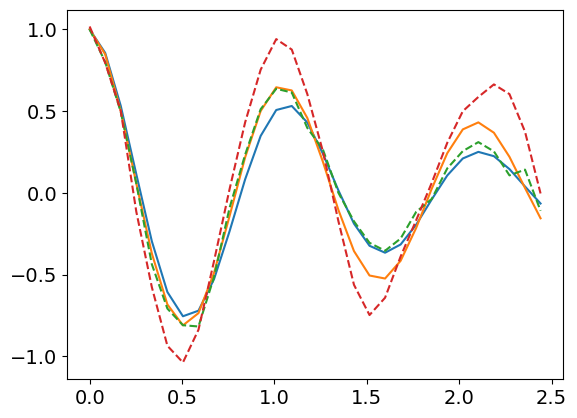

In [ ]:
plt.plot(times, dense_sim_flopping_decay[:,35])
print(dense_theta[35])
plt.plot(times, dense_sim_flopping_decay[:,0])
plt.plot(times, flopping_matrix_ps[:,0], linestyle='--')
plt.plot(times, ZNE_data_smooth, linestyle='--')

In [ ]:
theta_sub_index = [0, 1, 2, 3, 4]#,6]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))
print(theta_list[theta_sub_index_mask]/theta_list[0])

[1.         1.10210802 1.30632513 1.6126492  1.8168663 ]


[1.         1.10210802 1.30632513 1.6126492  1.8168663  2.02108235
 2.53162353 3.04216471 4.06324706]


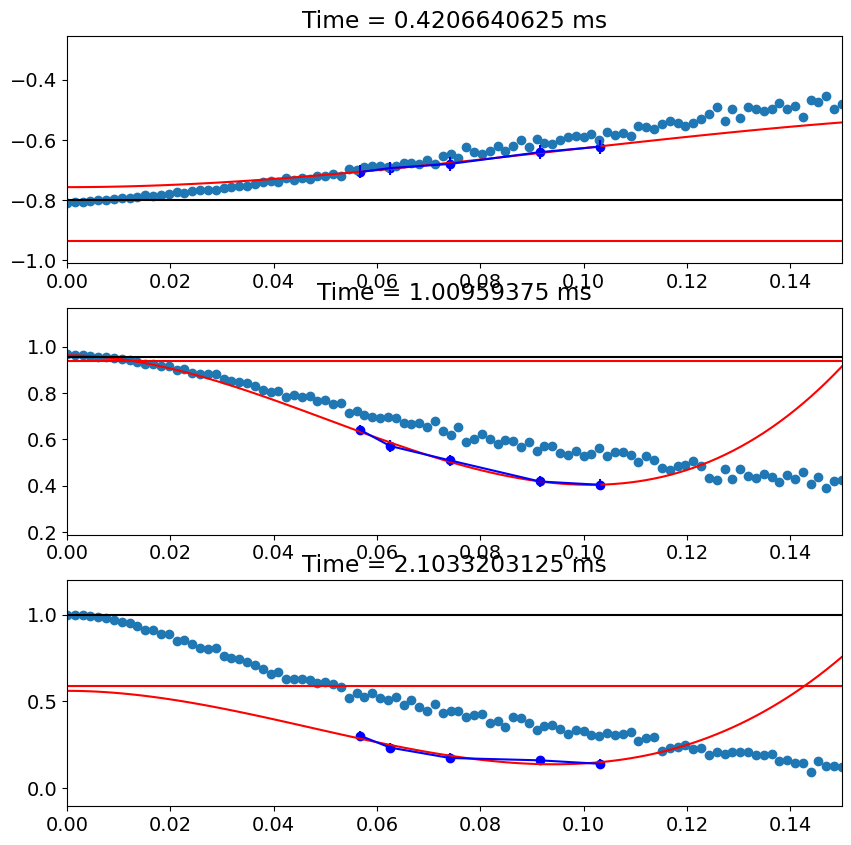

In [ ]:
peak_indices = [5,12,25]
#create 3 subplots. at the peak index, plot vs. theta, fit to cubic_no_first, and plot the fit
#thetas_sub_index = 
print(theta_list/theta_list[0])

def ZNE_fourth_no_first(times, y, weights = None):
    def fourth_no_first(t, a, b, c, d):
        return a + b*t + c*t**2 + d*t**3
    popt, pcov = curve_fit(fourth_no_first, times, y, sigma = weights)
    def return_func(t):
        return fourth_no_first(t, *popt)
    return return_func


ZNE_function = third_no_first_ZNE
#ZNE_function = gaussian_ZNE
fig, axes = plt.subplots(3)

for i in range(3):
    axis = axes[i]
    axis.scatter(theta_list[theta_sub_index_mask], flopping_ps_smoothed[peak_indices[i],theta_sub_index_mask], label = 'Data (Filtered)', color = 'blue')
    axis.errorbar(theta_list[theta_sub_index_mask], flopping_ps_smoothed[peak_indices[i],theta_sub_index_mask], yerr = flopping_std_matrix[peak_indices[i],theta_sub_index_mask]/np.sqrt(shots)*weights_comp, label = 'Data', color = 'blue')
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_ps_smoothed[peak_indices[i],theta_sub_index_mask], weights=flopping_std_matrix[peak_indices[i],theta_sub_index_mask]/np.sqrt(shots)*weights_comp)#, flopping_matrix[peak_indices[i],1], flopping_matrix[peak_indices[i],2], flopping_matrix[peak_indices[i],3])
    axis.plot(dense_theta, fit_func(dense_theta), label = 'Fit', color = 'red')
    axis.set_title('Time = ' + str(times[peak_indices[i]]) + ' ms')
    axis.scatter(dense_theta, dense_sim_flopping[peak_indices[i],:])
    #axis.scatter(dense_theta[37], dense_sim_flopping_decay[peak_indices[i],21], color = 'red')
    axis.set_xlim(0, 0.15)
    axis.set_ylim(min(dense_sim_flopping[peak_indices[i],:])-0.2,max(dense_sim_flopping[peak_indices[i],:]+0.2))
    axis.hlines(ZNE_data_smooth[peak_indices[i]], 0, 0.15, color = 'red', label='Smooth ZNE result')
    axis.hlines(exact[peak_indices[i]], 0, 0.15, color = 'black')
    #Make the plots bigger:
    
fig.set_size_inches(10, 10)
    
    
    

In [ ]:
theta_sub_index = [0,1,2,3,4,5]#[0, 1, 2, 3, 4]#,6]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))
print(theta_list[theta_sub_index_mask]/theta_list[0])

[1.         1.10210802 1.30632513 1.6126492  1.8168663  2.02108235]


[1.         1.10210802 1.30632513 1.6126492  1.8168663  2.02108235
 2.53162353 3.04216471 4.06324706]


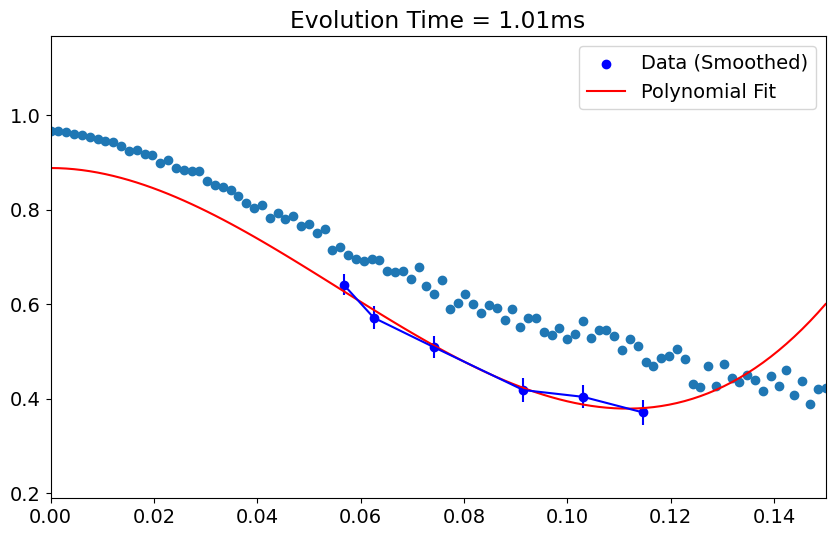

In [ ]:
peak_indices = [12]
#create 3 subplots. at the peak index, plot vs. theta, fit to cubic_no_first, and plot the fit
#thetas_sub_index = 
print(theta_list/theta_list[0])

def ZNE_fourth_no_first(times, y, weights = None):
    def fourth_no_first(t, a, b, c, d):
        return a + b*t + c*t**2 + d*t**3
    popt, pcov = curve_fit(fourth_no_first, times, y, sigma = weights)
    def return_func(t):
        return fourth_no_first(t, *popt)
    return return_func

ZNE_function = third_no_first_ZNE
#ZNE_function = gaussian_ZNE
fig, axes = plt.subplots(1)
axes = [axes]

for i in range(1):
    axis = axes[i]
    axis.scatter(theta_list[theta_sub_index_mask], flopping_ps_smoothed[peak_indices[i],theta_sub_index_mask], label = 'Data (Smoothed)', color = 'blue')
    axis.errorbar(theta_list[theta_sub_index_mask], flopping_ps_smoothed[peak_indices[i],theta_sub_index_mask], yerr = flopping_std_matrix[peak_indices[i],theta_sub_index_mask]/np.sqrt(shots)*weights_comp, color = 'blue')
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_ps_smoothed[peak_indices[i],theta_sub_index_mask], weights=flopping_std_matrix[peak_indices[i],theta_sub_index_mask]/np.sqrt(shots)*weights_comp)#, flopping_matrix[peak_indices[i],1], flopping_matrix[peak_indices[i],2], flopping_matrix[peak_indices[i],3])
    axis.plot(dense_theta, fit_func(dense_theta), label = 'Polynomial Fit', color = 'red')
    axis.set_title('Evolution Time = {:.2f}ms'.format(times[peak_indices[i]]))
    axis.scatter(dense_theta, dense_sim_flopping[peak_indices[i],:])
    #axis.scatter(dense_theta[37], dense_sim_flopping_decay[peak_indices[i],21], color = 'red')
    axis.set_xlim(0, 0.15)
    axis.set_ylim(min(dense_sim_flopping[peak_indices[i],:])-0.2,max(dense_sim_flopping[peak_indices[i],:]+0.2))
    #axis.hlines(ZNE_data_smooth[peak_indices[i]], 0, 0.15, color = 'red', label='Smooth ZNE result')
    #axis.hlines(exact[peak_indices[i]], 0, 0.15, color = 'black')
    #Make the plots bigger:
    axis.legend()

fig.set_size_inches(10, 6)
    
    
    

In [ ]:
print(dense_theta[50])

0.07575757575757576


0.05303030303030303


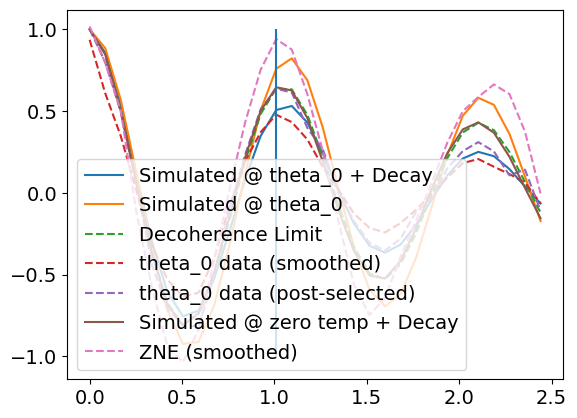

In [ ]:
plt.plot(times, dense_sim_flopping_decay[:,35], label='Simulated @ theta_0 + Decay')
plt.plot(times, dense_sim_flopping[:,35], label='Simulated @ theta_0')
print(dense_theta[35])
plt.plot(times, decoherence_limit, label='Decoherence Limit', linestyle='--')
plt.plot(times, flopping_matrix_smooth[:,0], linestyle='--', label='theta_0 data (smoothed)')
plt.plot(times, flopping_matrix_ps[:,0], linestyle='--', label='theta_0 data (post-selected)')
plt.plot(times, dense_sim_flopping_decay[:,0], label='Simulated @ zero temp + Decay')
plt.plot(times, ZNE_data_smooth, linestyle='--', label='ZNE (smoothed)')

for time_index in peak_indices:
    
    plt.vlines(times[time_index], -1, 1)
plt.legend()
#plt.plot(times, ZNE_data_smooth, linestyle='--')